<h4><strong>Problem Statement</strong></h4>
<ol>
<li><h5>Predict each player’s batting average at the end of the 2018 season given his batting statistics in March/April 2018. Use the first 28 columns to create prediction and the final column, FullSeason_AVG to test prediction accuracy. </h5></li>
<li><h5>Data is obtained from Fangraph - specifically https://questionnaire-148920.appspot.com/qa/batting.csv</h5></li>
</ol>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor, plot_importance

pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.3f}'.format

<h4><strong>Read in data from file & Delete unnecessary columns</strong></h4>

In [2]:
hits = pd.read_csv('batting.csv')
hits.head()

,playerid,Name,Team,PA,AB,H,HR,R,RBI,SB,BB%,K%,ISO,BABIP,AVG,OBP,SLG,LD%,GB%,FB%,IFFB%,HR/FB,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,FullSeason_AVG
0,11680,Elias Diaz,Pirates,34,31,15,2,6,6,0,0.088,0.088,0.194,0.500,0.484,0.529,0.677,0.250,0.500,0.250,0.143,0.286,0.303,0.656,0.472,0.500,0.975,0.817,0.286
1,12161,Xander Bogaerts,Red Sox,54,51,21,3,8,15,0,0.037,0.167,0.333,0.450,0.412,0.426,0.745,0.279,0.326,0.395,0.059,0.176,0.356,0.667,0.507,0.676,0.894,0.816,0.288
2,10816,Jedd Gyorko,Cardinals,30,22,8,2,5,5,1,0.200,0.200,0.318,0.400,0.364,0.500,0.682,0.235,0.235,0.529,0.111,0.222,0.295,0.596,0.408,0.522,0.821,0.686,0.262
3,13611,Mookie Betts,Red Sox,107,90,31,8,29,18,3,0.121,0.112,0.389,0.324,0.344,0.439,0.733,0.177,0.304,0.519,0.146,0.195,0.191,0.598,0.356,0.694,0.952,0.869,0.346
4,11493,Manny Machado,Orioles,125,108,39,9,14,22,2,0.136,0.128,0.315,0.361,0.361,0.448,0.676,0.163,0.359,0.478,0.205,0.205,0.289,0.711,0.458,0.654,0.891,0.801,0.297


In [3]:
# Save FullSeason_AVG column as numpy array and calculate mean/stdev for inverse scaling
FullSeason_AVG_mean = hits.FullSeason_AVG.mean()
FullSeason_AVG_std = hits.FullSeason_AVG.std()
FullSeason_AVG_actual = hits.FullSeason_AVG.values
# remove first three columns before training
hits.drop(['playerid', 'Name', 'Team'], axis=1, inplace=True)

<h4><strong>Pre-processing</strong></h4>
<ol>
    <li><h5> All input parameters are continuous numbers - no categorical-encoding (e.g., One Hot or Binary) is necessary</h5></li>
    <li><h5> Scale data using Scikits StandardScaler</h5></li>
</ol>        

In [4]:
cols = list(hits.columns.values)
hits[cols] = hits[cols].astype(float)
hits[cols] = StandardScaler().fit_transform(hits[cols])
hits.head()

,PA,AB,H,HR,R,RBI,SB,BB%,K%,ISO,BABIP,AVG,OBP,SLG,LD%,GB%,FB%,IFFB%,HR/FB,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,FullSeason_AVG
0,-1.794,-1.766,-0.544,-0.297,-0.831,-0.711,-0.652,-0.072,-1.652,0.348,2.964,4.124,3.193,2.179,0.673,0.820,-1.286,0.398,1.818,0.076,-0.136,0.255,-1.102,1.945,0.644,1.115
1,-1.117,-0.999,0.186,0.149,-0.469,0.874,-0.652,-1.195,-0.651,1.996,2.233,2.855,1.576,2.744,1.146,-1.032,0.291,-0.585,0.605,0.822,0.019,0.846,0.431,0.611,0.629,1.178
2,-1.929,-2.111,-1.396,-0.297,-1.012,-0.888,-0.120,2.395,-0.233,1.818,1.502,2.010,2.737,2.220,0.428,-2.000,1.747,0.023,1.112,-0.037,-0.976,-0.826,-0.910,-0.592,-1.237,0.352
3,0.676,0.497,1.404,2.376,3.330,1.402,0.942,0.655,-1.348,2.660,0.390,1.657,1.780,2.644,-0.518,-1.266,1.639,0.433,0.815,-1.502,-0.948,-1.705,0.588,1.566,1.390,3.021
4,1.285,1.187,2.377,2.822,0.617,2.107,0.411,0.985,-1.145,1.782,0.931,1.957,1.921,2.170,-0.747,-0.681,1.193,1.123,0.925,-0.122,0.635,0.018,0.240,0.561,0.414,1.464


<h4><strong>Create correlation heat map to look for relationships in parameters in hits table</strong></h4>

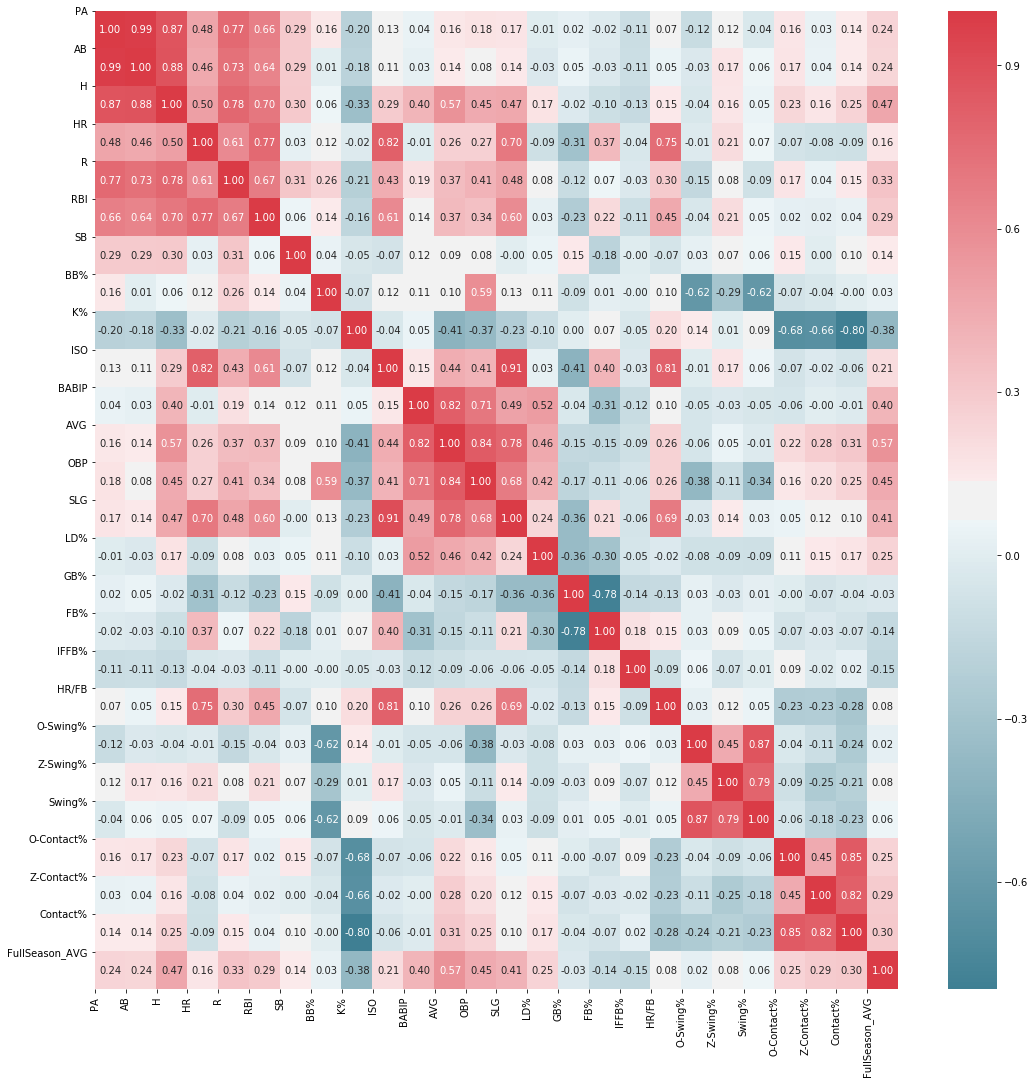

In [5]:
#Create Correlation data
corr = hits.corr()
#Plot figsize
fig, ax = plt.subplots(figsize=(18, 18))
#Generate Color Map
colormap = sns.diverging_palette(220, 10, as_cmap=True)
#Generate Heat Map, allow annotations and place floats in map
sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
#Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
#Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
#show plot
plt.show()

<h4><strong>Correlation indicates that March/April hitting, input parameters have highest correlation with Fullseason_AVG (as expected)</strong></h4>
<ol>
    <li><h5>Make train/test split on train_data</h5></li>
    <li><h5>Apply XGBRegressor (Gradient Boosted Trees for Regression)</h5></li>
</ol>
<h4><strong>Optimize  XGBRegressor parameters with GridsearchCV</strong></h4>
<ol>
    <li><h5>The number and size of trees (n_estimators and max_depth)</h5>
    <li><h5>The learning rate</h5>
    <li><h5>L1 (analogous to Lasso regression) and L2 (analogous to Ridge regression) regularization terms</h5>
    <li><h5>Since data volume is fairly low, use cross validation split = 2</h5>
</ol>

In [6]:
y = hits.FullSeason_AVG
del hits['FullSeason_AVG']

X_train, X_test, y_train, y_test = train_test_split(hits, y, test_size=0.1, random_state=42)

In [7]:
n_estimators = [10, 30, 50, 70, 90]
max_depth = [2, 3, 4, 5]
learning_rate = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1.0]
reg_alpha = [0.005, 0.01, 0.025 ,0.05, 0.1, 0.3, 0.5]
reg_lambda = [0.05, 0.1, 0.25, 0.5, 1, 1.5, 2]
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate, reg_alpha=reg_alpha, reg_lambda=reg_lambda, objective=['reg:squarederror'])

xgb = XGBRegressor()
# small dataset - split twice for cross validation with GridSearchCV
kfold = KFold(n_splits=2, shuffle=True, random_state=7)
grid_search = GridSearchCV(xgb, param_grid, scoring="neg_mean_squared_error", n_jobs=-1, cv=kfold, return_train_score=True)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print('Best: {:.2f} using {} \n '.format(grid_result.best_score_, grid_result.best_params_))

Best: -0.76 using {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 30, 'objective': 'reg:squarederror', 'reg_alpha': 0.3, 'reg_lambda': 1.5} 
 


C:\Users\Barnwaldo\Anaconda3\envs\ml\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Train Errors after 23 epochs: 
     RMSE = 0.728646
     MAE  = 0.58526
Validation Errors after 23 epochs: 
     RMSE = 0.729389
     MAE  = 0.539541


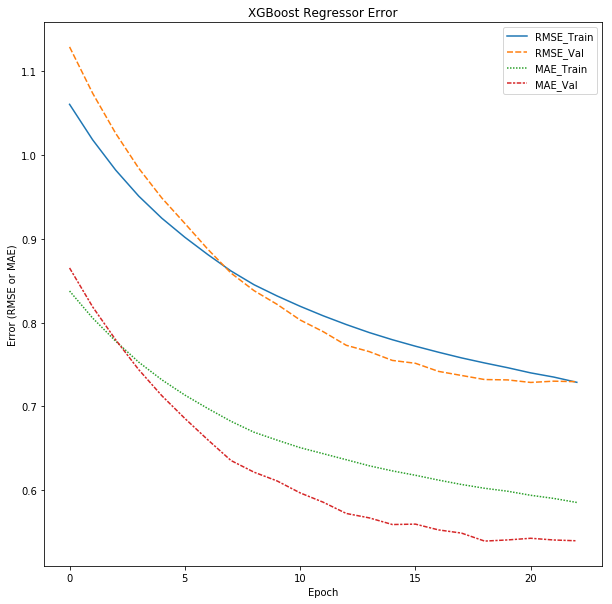

In [8]:
x = XGBRegressor(random_state=44, n_jobs=4, n_estimators=30, max_depth=2, learning_rate=0.1, reg_alpha=0.3, reg_lambda=1.5, verbosity=0)
eval_set = [(X_train, y_train), (X_test, y_test)]
x.fit(X_train, y_train, eval_metric=['rmse', 'mae'], eval_set=eval_set, verbose=False, early_stopping_rounds=5)
predictions = x.predict(X_test)
results = x.evals_result()
epochs = len(results['validation_0']['rmse'])
print("Train Errors after {} epochs: \n     RMSE = {}\n     MAE  = {}".format(epochs, results['validation_0']['rmse'][-1], results['validation_0']['mae'][-1] ))
print("Validation Errors after {} epochs: \n     RMSE = {}\n     MAE  = {}".format(epochs, results['validation_1']['rmse'][-1], results['validation_1']['mae'][-1] ))
# plot errors
fig, ax = plt.subplots(figsize=(10, 10))
d = {'RMSE_Train': results['validation_0']['rmse'], 'RMSE_Val': results['validation_1']['rmse'], 'MAE_Train': results['validation_0']['mae'], 'MAE_Val': results['validation_1']['mae'],}
df = pd.DataFrame(data=d)
ax = sns.lineplot(data=df)
plt.xlabel('Epoch')
plt.ylabel('Error (RMSE or MAE)')
plt.title('XGBoost Regressor Error')
plt.show()

<h4><strong>Examine feature importance</strong></h4>
<h5>Weight (F-score) is number of times a variable is selected for splitting, weighted by the squared improvement to the model as a result of each split, and averaged over all trees.</h5>

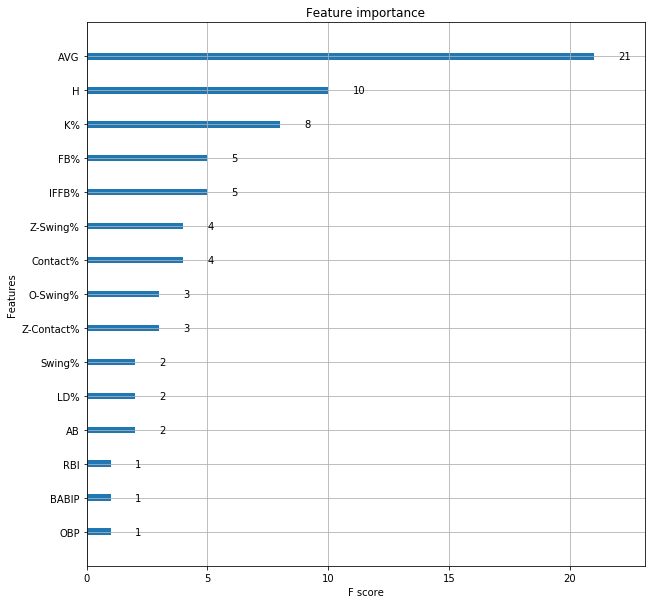

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_importance(x, ax=ax)
plt.show()

<h4><strong>Predict Results for entire data set and create new dataframe</strong></h4>

In [10]:
FullSeason_AVG_predicted = x.predict(hits) * FullSeason_AVG_std + FullSeason_AVG_mean
hits = pd.read_csv('batting.csv')
hits.drop(['SB', 'BB%', 'K%', 'ISO', 'BABIP', 'SLG', 'LD%', 'GB%', 'FB%', 'IFFB%', 'HR/FB', 'O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%', 'Z-Contact%', 'Contact%'], axis=1, inplace=True)
hits.insert(loc=len(hits.columns), column='Predicted_FullSeason_AVG', value=FullSeason_AVG_predicted)
hits.head(len(hits))

,playerid,Name,Team,PA,AB,H,HR,R,RBI,AVG,OBP,FullSeason_AVG,Predicted_FullSeason_AVG
0,11680,Elias Diaz,Pirates,34,31,15,2,6,6,0.484,0.529,0.286,0.275
1,12161,Xander Bogaerts,Red Sox,54,51,21,3,8,15,0.412,0.426,0.288,0.276
2,10816,Jedd Gyorko,Cardinals,30,22,8,2,5,5,0.364,0.500,0.262,0.265
3,13611,Mookie Betts,Red Sox,107,90,31,8,29,18,0.344,0.439,0.346,0.284
4,11493,Manny Machado,Orioles,125,108,39,9,14,22,0.361,0.448,0.297,0.278
5,6012,Didi Gregorius,Yankees,121,98,32,10,24,30,0.327,0.421,0.268,0.276
6,11739,J.T. Realmuto,Marlins,48,42,15,4,9,8,0.357,0.426,0.277,0.271
7,11738,Christian Villanueva,Padres,90,78,25,8,15,19,0.321,0.411,0.236,0.260
8,11205,Adam Eaton,Nationals,33,29,10,2,10,5,0.345,0.424,0.301,0.273
9,12927,Brandon Nimmo,Mets,43,32,10,1,9,3,0.313,0.488,0.263,0.259
